In [1]:
pip install pybbn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

### Code for Answer 1)

In [3]:
# Set Pandas options to display more columns
pd.options.display.max_columns=25

# Read in the weather data csv
df=pd.read_csv('weatherAUS.csv', encoding='utf-8')

In [4]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


Data Preprocessing:

In [5]:
# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns of numerical datatype with missing values, fill them in with column mean
df=df.fillna(df.mean())

<ipython-input-5-cd55ebeaa642>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


In [6]:
#Replacing missing values found in columns of datatype object with the mode
for col in df.select_dtypes(include=['object']):
    df[col].fillna(df[col].mode()[0], inplace=True)

In [7]:
df['WindGustDir'].mode()[0]

'W'

In [8]:
df['WindDir9am'].mode()

0    N
Name: WindDir9am, dtype: object

In [9]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,5.469824,7.624853,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503167,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,5.469824,7.624853,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.437189,4.503167,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,5.469824,7.624853,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.437189,2.000000,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,5.469824,7.624853,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.437189,4.503167,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,5.469824,7.624853,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,5.469824,7.624853,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,4.437189,4.503167,9.4,20.9,No,No
145455,2017-06-21,Uluru,2.8,23.4,0.0,5.469824,7.624853,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,4.437189,4.503167,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,5.469824,7.624853,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,4.437189,4.503167,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,5.469824,7.624853,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,4.437189,4.503167,12.5,26.1,No,No


In [10]:
#Finding the number of missing values in each column
df.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

### Code for Answer 2)

In [11]:
# Create bands for variables that we want to use in the model
df['Temp9amCat']=df['Temp9am'].apply(lambda x: 'cat 1: x<15 ' if x<15 else 'cat 2: 15<=x<=26' if 15<x<=26 else 'cat 3: x>26')
df['Temp3pmCat']=df['Temp3pm'].apply(lambda x: 'cat 2: x<24' if x<24 else 'cat 2: 24<=x<=36' if 24<=x<=36 else 'cat 3: x>36')
df['WindSpeed9amCat']=df['WindSpeed9am'].apply(lambda x: 'cat 1: x<16' if x<16 else 'cat 2: x>=16')
df['WindSpeed3pmCat']=df['WindSpeed3pm'].apply(lambda x: 'cat 1: x<15' if x<15 else 'cat 2: x>=15')

# print the data
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Temp9amCat,Temp3pmCat,WindSpeed9amCat,WindSpeed3pmCat
0,2008-12-01,Albury,13.4,22.9,0.6,5.469824,7.624853,W,44.0,W,WNW,20.0,...,1007.7,1007.1,8.000000,4.503167,16.9,21.8,No,No,cat 2: 15<=x<=26,cat 2: x<24,cat 2: x>=16,cat 2: x>=15
1,2008-12-02,Albury,7.4,25.1,0.0,5.469824,7.624853,WNW,44.0,NNW,WSW,4.0,...,1010.6,1007.8,4.437189,4.503167,17.2,24.3,No,No,cat 2: 15<=x<=26,cat 2: 24<=x<=36,cat 1: x<16,cat 2: x>=15
2,2008-12-03,Albury,12.9,25.7,0.0,5.469824,7.624853,WSW,46.0,W,WSW,19.0,...,1007.6,1008.7,4.437189,2.000000,21.0,23.2,No,No,cat 2: 15<=x<=26,cat 2: x<24,cat 2: x>=16,cat 2: x>=15
3,2008-12-04,Albury,9.2,28.0,0.0,5.469824,7.624853,NE,24.0,SE,E,11.0,...,1017.6,1012.8,4.437189,4.503167,18.1,26.5,No,No,cat 2: 15<=x<=26,cat 2: 24<=x<=36,cat 1: x<16,cat 1: x<15
4,2008-12-05,Albury,17.5,32.3,1.0,5.469824,7.624853,W,41.0,ENE,NW,7.0,...,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No,cat 2: 15<=x<=26,cat 2: 24<=x<=36,cat 1: x<16,cat 2: x>=15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,5.469824,7.624853,E,31.0,ESE,E,15.0,...,1024.7,1021.2,4.437189,4.503167,9.4,20.9,No,No,cat 1: x<15,cat 2: x<24,cat 1: x<16,cat 1: x<15
145455,2017-06-21,Uluru,2.8,23.4,0.0,5.469824,7.624853,E,31.0,SE,ENE,13.0,...,1024.6,1020.3,4.437189,4.503167,10.1,22.4,No,No,cat 1: x<15,cat 2: x<24,cat 1: x<16,cat 1: x<15
145456,2017-06-22,Uluru,3.6,25.3,0.0,5.469824,7.624853,NNW,22.0,SE,N,13.0,...,1023.5,1019.1,4.437189,4.503167,10.9,24.5,No,No,cat 1: x<15,cat 2: 24<=x<=36,cat 1: x<16,cat 1: x<15
145457,2017-06-23,Uluru,5.4,26.9,0.0,5.469824,7.624853,N,37.0,SE,WNW,9.0,...,1021.0,1016.8,4.437189,4.503167,12.5,26.1,No,No,cat 1: x<15,cat 2: 24<=x<=36,cat 1: x<16,cat 1: x<15


### Code for Answer 3)

In [12]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [13]:
# Create nodes by using our earlier function to automatically calculate probabilities
T9am = BbnNode(Variable(0, 'T9am', ['<15', '15-26', '>26']), probs(df, child='Temp9amCat'))
T3pm = BbnNode(Variable(1, 'T3pm', ['<24', '24-36', '>36']), probs(df, child='Temp3pmCat', parent1='Temp9amCat'))
WS9am = BbnNode(Variable(2, 'WS9am', ['<16', '>=16']), probs(df, child='WindSpeed9amCat'))
WS3pm = BbnNode(Variable(3, 'WS3pm', ['<15', '>=15']), probs(df, child='WindSpeed3pmCat', parent1='WindSpeed9amCat'))
RT = BbnNode(Variable(4, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Temp3pmCat', parent2='WindSpeed3pmCat'))

# Create Network
bbn = Bbn() \
    .add_node(T9am) \
    .add_node(T3pm) \
    .add_node(WS9am) \
    .add_node(WS3pm) \
    .add_node(RT) \
    .add_edge(Edge(T9am, T3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(T3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(WS9am, WS3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(WS3pm, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

### Code for Answer 4)

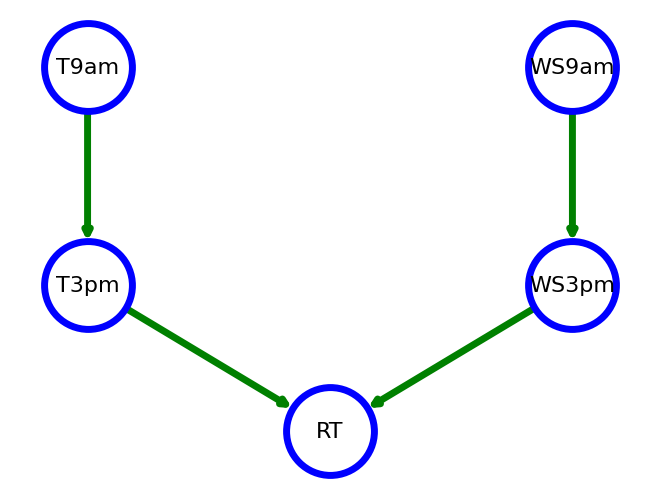

In [14]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 2), 3: (1, 0.5), 4: (0, -0.5)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "blue",
    "edge_color": "green",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [15]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
----------------
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.32668
1=24-36|0.64886
1=>36|0.02447
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.39733
0=15-26|0.50187
0=>26|0.10079
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.77556
4=Yes|0.22444
----------------


### Code for Answer 5)

In [16]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

In [17]:
# Use above function to add evidence
evidence('ev1', 'T9am', '15-26', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
----------------
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.49023
1=24-36|0.50018
1=>36|0.00960
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.00000
0=15-26|1.00000
0=>26|0.00000
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.79133
4=Yes|0.20867
----------------


In [18]:
# Use above function to add evidence
evidence('ev1', 'T9am', '<15', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
----------------
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.02476
1=24-36|0.97522
1=>36|0.00002
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|1.00000
0=15-26|0.00000
0=>26|0.00000
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.73665
4=Yes|0.26335
----------------


In [19]:
# Use above function to add evidence
evidence('ev1', 'T3pm', '24-36', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
----------------
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.00000
1=24-36|1.00000
1=>36|0.00000
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|1.00000
0=15-26|0.00000
0=>26|0.00000
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.73383
4=Yes|0.26617
----------------


In [20]:
# Use above function to add evidence
evidence('ev1', 'T3pm', '<24', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
----------------
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|1.00000
1=24-36|0.00000
1=>36|0.00000
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|1.00000
0=15-26|0.00000
0=>26|0.00000
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.84743
4=Yes|0.15257
----------------


In [21]:
# Use above function to add evidence
evidence('ev1', 'T9am', '<15', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
----------------
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|1.00000
1=24-36|0.00000
1=>36|0.00000
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.03012
0=15-26|0.75314
0=>26|0.21674
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.84743
4=Yes|0.15257
----------------


In [22]:
# Use above function to add evidence
evidence('ev1', 'T3pm', '<24', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
----------------
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.32668
1=24-36|0.64886
1=>36|0.02447
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.39733
0=15-26|0.50187
0=>26|0.10079
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.77556
4=Yes|0.22444
----------------
